In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '/home/561/jn8053/g_e14/figures-tmp/easterlies-collaborative/'

In [2]:
keys = ['ctrl', 'up', 'down']

In [3]:
session = cc.database.create_session()
experiment_ryf = '01deg_jra55v13_ryf9091'
experiment_eup = '01deg_jra55v13_ryf9091_easterlies_up10'
experiment_edo = '01deg_jra55v13_ryf9091_easterlies_down10'

ti = '2150-01-01'
tf = '2159-12-31'

In [4]:
# Load steric ssh
steric_ssh = {}
for k in keys:
    # Open with a - because I forgot to compute with a -
    steric_ssh[k] = -xr.open_dataset('steric_ssh_'+k+'.nc')['steric_ssh']

In [5]:
# Load sea level for comparison
ssh = {}
ssh['ctrl'] = cc.querying.getvar(experiment_ryf, 'sea_level', session, 
                                 start_time = ti, end_time = tf).sel(time = slice(ti, tf), 
                                                                     yt_ocean = slice(None, -58))
ssh['up'] = cc.querying.getvar(experiment_eup, 'sea_level', session, 
                               start_time = ti, end_time = tf).sel(time = slice(ti, tf), 
                                                                   yt_ocean = slice(None, -58))
ssh['down'] = cc.querying.getvar(experiment_edo, 'sea_level', session, 
                                 start_time = ti, end_time = tf).sel(time = slice(ti, tf), 
                                                                     yt_ocean = slice(None, -58))

# On-shelf time series

In [6]:
# Load mass change term
mass_term = {}
for k in keys:
    mass_term[k] = xr.open_dataset('mass_term_shelf_ave_'+k+'.nc')['mass_term']

In [7]:
# Create a shelf mask
ht = cc.querying.getvar(experiment_ryf, 'ht', session, n = 1).sel(yt_ocean = slice(None, -58))

iso = xr.open_dataset('~/g_e14/misc/Antarctic_isobath_1000m.nc')
lat_slice = slice(-80,-58)
lon_slice = slice(-280, 80)

def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    # Mask values that are non-zero
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    # Multiply the variable with the mask, we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = lat_slice) * shelf_mask
    return masked_var, shelf_map

ht_masked, shelf_mask = shelf_mask_isobath(ht)

# Area for weighting
area_t = cc.querying.getvar(experiment_ryf, 'area_t', session, ncfile = 'ocean_grid.nc', n = -1)
area_t = area_t.sel(yt_ocean = slice(None, -58)).sel(xt_ocean = lon_slice)
area_t = area_t * shelf_mask.sel(yt_ocean = lat_slice).sel(xt_ocean = lon_slice)
area_sum = area_t.sum('xt_ocean').sum('yt_ocean')

In [8]:
# Averaging on shelf
steric_ssh_shelf = {}
for k in keys:
    steric_ssh_shelf[k], shelf_mask = shelf_mask_isobath(steric_ssh[k])
    steric_ssh_shelf[k] = (steric_ssh_shelf[k]*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum
    steric_ssh_shelf[k] = steric_ssh_shelf[k].load()

In [9]:
# Averaging on shelf
ssh_shelf = {}
for k in keys:
    ssh_shelf[k], shelf_mask = shelf_mask_isobath(ssh[k])
    ssh_shelf[k] = (ssh_shelf[k]*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum
    ssh_shelf[k] = ssh_shelf[k].load()

Plot anomalies with respect to control of:
1. Sea level anomales from model output
2. Steric sea level anomalies + mass term changes

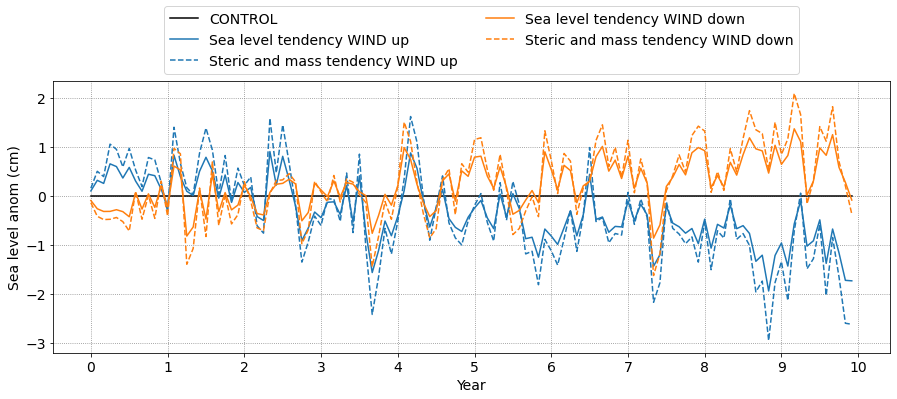

In [51]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (15, 5))
axs = fig.add_subplot()
axs.plot(np.arange(0, 120, 1), 0*ssh_shelf['ctrl'], 'k', label = 'CONTROL')
for k, clr in zip(keys[1:], ['C0', 'C1']):
    axs.plot(np.arange(0, 120, 1), 100*(ssh_shelf[k]-ssh_shelf['ctrl']), color = clr, 
             label = 'Sea level tendency WIND '+k)
    axs.plot(np.arange(0, 120, 1), 
             100*((mass_term[k] - mass_term['ctrl']) + \
                  (steric_ssh_shelf[k][:-12] - steric_ssh_shelf['ctrl'][:-12])),
             linestyle = '--', color = clr, label = 'Steric and mass tendency WIND '+k)
axs.grid(linestyle = ':', color = 'grey')
axs.set_ylabel('Sea level anom (cm)')
axs.set_xticks(np.arange(0, 132, 12))
axs.set_xticklabels(np.arange(0, 11, 1))
axs.set_xlabel('Year');
axs.legend(ncol = 2, bbox_to_anchor = (0.9, 1.3), loc = 'upper right')
plt.savefig('ssh-stericssh-massterm-anom-timeseries.jpg', bbox_inches = 'tight')

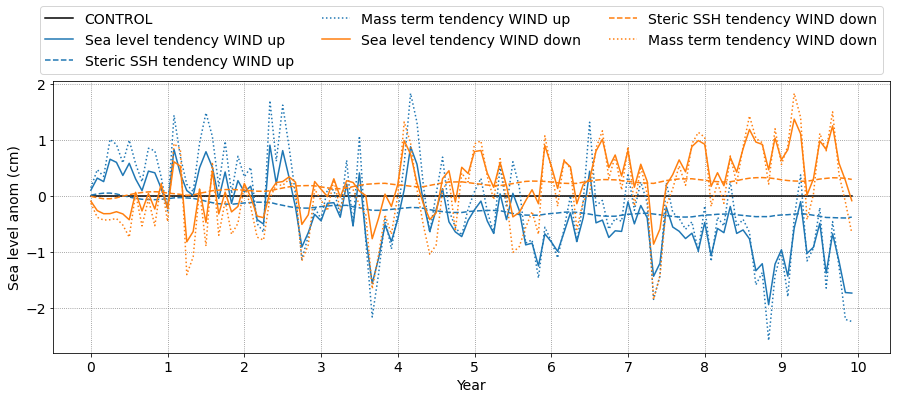

In [60]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (15, 5))
axs = fig.add_subplot()
axs.plot(np.arange(0, 120, 1), 0*ssh_shelf['ctrl'], 'k', label = 'CONTROL')
for k, clr in zip(keys[1:], ['C0', 'C1']):
    axs.plot(np.arange(0, 120, 1), 100*(ssh_shelf[k]-ssh_shelf['ctrl']), color = clr, 
             label = 'Sea level tendency WIND '+k)
    axs.plot(np.arange(0, 120, 1), 
             100*((steric_ssh_shelf[k][:-12] - steric_ssh_shelf['ctrl'][:-12])),
             linestyle = '--', color = clr, label = 'Steric SSH tendency WIND '+k)
    axs.plot(np.arange(0, 120, 1), 
             100*((mass_term[k] - mass_term['ctrl'])),
             linestyle = ':', color = clr, label = 'Mass term tendency WIND '+k)
axs.grid(linestyle = ':', color = 'grey')
axs.set_ylabel('Sea level anom (cm)')
axs.set_xticks(np.arange(0, 132, 12))
axs.set_xticklabels(np.arange(0, 11, 1))
axs.set_xlabel('Year');
axs.legend(ncol = 3, bbox_to_anchor = (1, 1.3), loc = 'upper right')
plt.savefig('ssh-stericssh-massterm-separated-anom-timeseries.jpg', bbox_inches = 'tight')

In [61]:
import scipy.stats as st

In [63]:
st.linregress(np.arange(0, 120, 1), mass_term['up']-mass_term['ctrl'])

LinregressResult(slope=-0.00015206375720807434, intercept=0.007211652564554482, rvalue=-0.6002120129498459, pvalue=4.3151336629406605e-13, stderr=1.8654502150812683e-05, intercept_stderr=0.0012843413618478445)

In [64]:
st.linregress(np.arange(0, 120, 1), mass_term['down']-mass_term['ctrl'])

LinregressResult(slope=8.915884559854416e-05, intercept=-0.004799885418427692, rvalue=0.4310195592645436, pvalue=8.907828574267751e-07, stderr=1.718295719260578e-05, intercept_stderr=0.0011830271568176421)

In [65]:
st.linregress(np.arange(0, 120, 1), steric_ssh_shelf['up'][:-12] - steric_ssh_shelf['ctrl'][:-12])

LinregressResult(slope=-3.2024446504605394e-05, intercept=-0.0005152352507845461, rvalue=-0.9311920300367872, pvalue=1.5131254727659557e-53, stderr=1.154073532923039e-06, intercept_stderr=7.945665668072283e-05)

In [66]:
st.linregress(np.arange(0, 120, 1), steric_ssh_shelf['down'][:-12] - steric_ssh_shelf['ctrl'][:-12])

LinregressResult(slope=2.572608515295068e-05, intercept=0.0003758198264236742, rvalue=0.922572611193216, pvalue=1.2396873500410466e-50, stderr=9.904232434892816e-07, intercept_stderr=6.818951945567557e-05)

In [22]:
thermosteric_ssh = {}
halosteric_ssh = {}
for k in keys:
    # Open with a - because I forgot to compute with a -
    thermosteric_ssh[k] = -xr.open_dataset('thermosteric_ssh_'+k+'.nc')['thermosteric_ssh']
    halosteric_ssh[k] = -xr.open_dataset('halosteric_ssh_'+k+'.nc')['halosteric_ssh']

In [26]:
# Averaging on shelf
thermosteric_ssh_shelf = {}
for k in keys:
    thermosteric_ssh_shelf[k], shelf_mask = shelf_mask_isobath(thermosteric_ssh[k])
    thermosteric_ssh_shelf[k] = (thermosteric_ssh_shelf[k]*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum
    thermosteric_ssh_shelf[k] = thermosteric_ssh_shelf[k].load()

In [27]:
# Averaging on shelf
halosteric_ssh_shelf = {}
for k in keys:
    halosteric_ssh_shelf[k], shelf_mask = shelf_mask_isobath(halosteric_ssh[k])
    halosteric_ssh_shelf[k] = (halosteric_ssh_shelf[k]*area_t).sum('xt_ocean').sum('yt_ocean') / area_sum
    halosteric_ssh_shelf[k] = halosteric_ssh_shelf[k].load()

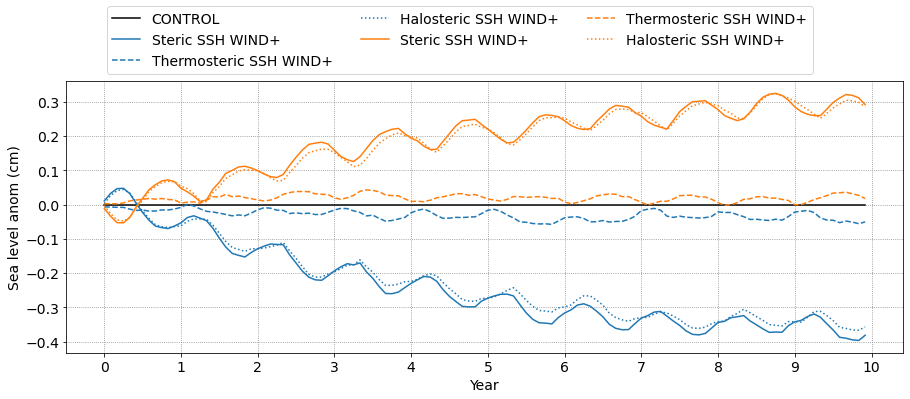

In [50]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (15, 5))
axs = fig.add_subplot()
axs.plot(np.arange(0, 120, 1), 0*ssh_shelf['ctrl'], 'k', label = 'CONTROL')
for k, clr in zip(['up', 'down'], ['C0', 'C1']):
    # Steric ssh
    axs.plot(np.arange(0, 120, 1), 
             100*((steric_ssh_shelf[k][:-12] - steric_ssh_shelf['ctrl'][:-12])),
             linestyle = '-', color = clr, label = 'Steric SSH WIND+')
    # Thermoteric ssh
    axs.plot(np.arange(0, 120, 1), 
             100*((thermosteric_ssh_shelf[k][:-12] - thermosteric_ssh_shelf['ctrl'][:-12])),
             linestyle = '--', color = clr, label = 'Thermosteric SSH WIND+')
    # Halosteric ssh
    axs.plot(np.arange(0, 120, 1), 
             100*((halosteric_ssh_shelf[k][:-12] - halosteric_ssh_shelf['ctrl'][:-12])),
             linestyle = ':', color = clr, label = 'Halosteric SSH WIND+')
axs.grid(linestyle = ':', color = 'grey')
axs.set_ylabel('Sea level anom (cm)')
axs.set_xticks(np.arange(0, 132, 12))
axs.set_xticklabels(np.arange(0, 11, 1))
axs.set_xlabel('Year');
axs.legend(ncol = 3, bbox_to_anchor = (0.9, 1.3), loc = 'upper right')
plt.savefig('stericssh-thermohalosteric-up-timeseries.jpg', bbox_inches = 'tight')

# Maps

In [67]:
import dask.distributed as dsk
import sys
sys.path.insert(0, '/home/561/jn8053/~/.local/lib')
from xarrayMannKendall import *
clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44455/status,
Dashboard: /proxy/44455/status,Workers: 4
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40569,Workers: 4
Dashboard: /proxy/44455/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:33959,Total threads: 4
Dashboard: /proxy/41083/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:37731,


In [ ]:
MK_class = Mann_Kendall_test((steric_ssh['up']-steric_ssh['ctrl']), 'time', 
                             coords_name = {'time':'time', 'yt_ocean':'y', 'xt_ocean':'x'})
steric_ssh_trend['up'] = MK_class.compute()
steric_ssh_trend['up'] = steric_ssh_trend['up'].rename({'x':'xt_ocean', 'y':'yt_ocean'})

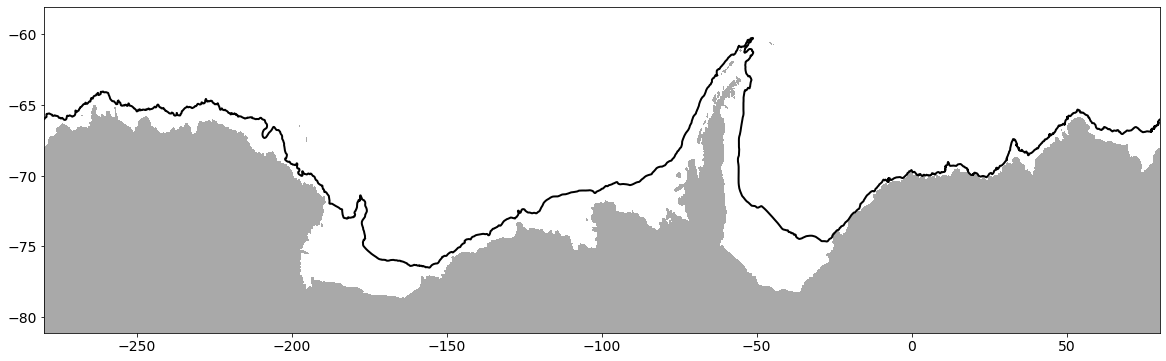

In [54]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (20, 6))
axs = fig.add_subplot()
axs.contourf(ht['xt_ocean'], ht['yt_ocean'], xr.where(np.isnan(ht), 1, np.nan), 
             colors = 'darkgrey', linewidths = 0.5, 
             zorder = 2)
axs.plot(iso['x'], iso['y'], 'k', linewidth = 2, zorder = 2)